In [7]:
import pandas as pd
import pypsa
import numpy as np
network = pypsa.Network()

In [8]:
bus = pd.read_csv('data/base_grid/bus.csv')
sub = pd.read_csv('data/base_grid/sub.csv')
sub = sub.drop(columns = 'interconnect')
bus2sub = pd.read_csv('data/base_grid/bus2sub.csv')
bus2sub = bus2sub.drop(columns = 'interconnect')

In [9]:
buses = bus.merge(bus2sub, how = 'left', on='bus_id')
buses = buses.merge(sub,how='left',on='sub_id')

In [10]:
buses['Va'] = buses['Va'].apply(np.deg2rad)
buses['control'] = buses['type'].map({1:'PQ',2:'PV'})
buses.drop(inplace=True,columns = ['type'])
buses.dropna(subset=['control'],inplace=True)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [11]:
texas = buses[buses['interconnect'] == 'Texas']

In [6]:
texas = texas.set_index('bus_id')
buses_columns = {'lat':'y',
                                'lon':'x',
                                'Vm':'v_mag_pu',
                                'Pd':'p',
                                'Qd':'q',
                                'Va':'v_ang',
                                'baseKV':'v_nom',
                                'Vmax':'v_mag_pu_max',
                                'Vmin':'v_mag_pu_min'}

texas = texas.rename(columns = buses_columns)
texas = texas[buses_columns.values()]

In [7]:
network.import_components_from_dataframe(texas.dropna(),"Bus")

In [12]:
generators = pd.read_csv('data/base_grid/plant.csv')
cost = pd.read_csv('data/base_grid/gencost.csv')
hydro = pd.read_csv('data/base_grid/hydro.csv')
solar = pd.read_csv('data/base_grid/solar.csv')
wind = pd.read_csv('data/base_grid/wind.csv')
outputs = solar.merge(hydro).merge(wind)
generators = generators.merge(cost.drop(columns = ['type','interconnect']),how='left',on='plant_id')
generators = generators.merge(bus.drop(columns = ['type', 'interconnect']),how='left',on='bus_id')
generators = generators.merge(bus[['bus_id','type']].rename(columns = {'type':'control'}),how='left',on='bus_id')


In [13]:
texas_generators = generators[generators.interconnect == 'Texas'].copy()

In [14]:
texas_generators

,plant_id,bus_id,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,...,Va,baseKV,loss_zone,Vmax,Vmin,lam_P,lam_Q,mu_Vmax,mu_Vmin,control
12875,12875,3001004,158.25,-30.38,44.94,-30.38,1.01,253.20,1,211.0,...,-19.32470,230.0,9,1.1,0.9,0.0,0,0,0,2
12876,12876,3001006,25.73,-4.94,7.31,-4.94,1.00,41.16,1,34.3,...,-13.78150,13.8,9,1.1,0.9,0.0,0,0,0,2
12877,12877,3001009,61.87,-11.88,17.57,-11.88,1.00,99.00,1,82.5,...,-5.33886,13.8,9,1.1,0.9,0.0,0,0,0,2
12878,12878,3001011,9.99,0.00,0.00,0.00,1.00,12.00,1,10.0,...,-14.83920,22.0,9,1.1,0.9,0.0,0,0,0,2
12879,12879,3001021,149.63,-28.73,42.49,-28.73,1.00,239.40,1,199.5,...,-8.62704,13.8,9,1.1,0.9,0.0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14045,14045,3001028,0.00,0.00,0.00,0.00,1.00,200.00,1,155.4,...,-18.22760,115.0,9,1.1,0.9,0.0,0,0,0,1
14046,14046,3002048,0.00,0.00,0.00,0.00,1.00,200.00,1,151.2,...,-32.24660,161.0,10,1.1,0.9,0.0,0,0,0,1
14047,14047,3003142,0.00,0.00,0.00,0.00,1.00,200.00,1,150.0,...,-39.83280,115.0,27,1.1,0.9,0.0,0,0,0,1
14048,14048,3003051,0.00,0.00,0.00,0.00,1.00,200.00,1,149.3,...,-35.44670,115.0,28,1.1,0.9,0.0,0,0,0,1


In [15]:
def output(row):
    try:
        return list(outputs[str(row['plant_id'])])
    except Exception as e:
        return np.nan

In [16]:
texas_generators['output'] = texas_generators.apply(lambda x: output(x), axis=1)

In [17]:
texas_generators_w_series = texas_generators[texas_generators['output'].notna()].copy()
texas_generators_wout_series = texas_generators[texas_generators['output'].isna()].copy()


In [18]:
texas_generators_wout_series['output'].fillna(texas_generators_wout_series['Pg'],inplace=True)

In [19]:
# pop = generators[generators['output'].isna()].drop(columns = ['output']).nunique(dropna=False) == generators[generators['output'].notna()].drop(columns = ['output']).nunique(dropna=False)

In [20]:
power_as_series = texas_generators['Pg'].apply(lambda x: [x]*8784)
texas_generators['output'].fillna(power_as_series,inplace=True)

In [21]:
texas_generators.set_index('plant_id',inplace=True)
texas_generators['control'] = texas_generators['control'].map({1:'PQ',2:'PV'})
generator_rename = {'bus_id':'bus',
                    'output':'p',
                    'Pg':'p_nom',
                    'Pmin':'p_nom_min',
                    'Pmax':'p_nom_max',
                    'type':'carrier',
                    'startup':'start_up_cost',
                    'shutdown':'shut_down_cost',
                    'marginal_cost':'c1',
                    'Qg':'q'}
texas_generators.rename(columns = generator_rename,inplace=True)


In [22]:
texas_generators.columns

Index(['bus', 'p_nom', 'q', 'Qmax', 'Qmin', 'Vg', 'mBase', 'status',
       'p_nom_max', 'p_nom_min', 'Pc1', 'Pc2', 'Qc1min', 'Qc1max', 'Qc2min',
       'Qc2max', 'ramp_agc', 'ramp_10', 'ramp_30', 'ramp_q', 'apf', 'mu_Pmax',
       'mu_Pmin', 'mu_Qmax', 'mu_Qmin', 'carrier', 'interconnect',
       'GenFuelCost', 'GenIOB', 'GenIOC', 'GenIOD', 'start_up_cost',
       'shut_down_cost', 'n', 'c2', 'c1', 'c0', 'Pd', 'Qd', 'Gs', 'Bs',
       'zone_id', 'Vm', 'Va', 'baseKV', 'loss_zone', 'Vmax', 'Vmin', 'lam_P',
       'lam_Q', 'mu_Vmax', 'mu_Vmin', 'control', 'p'],
      dtype='object')

In [15]:
texas_generators.drop(13253,inplace=True)

In [16]:
texas_generators.head()

,bus,p_nom,q,Qmax,Qmin,Vg,mBase,status,p_nom_max,p_nom_min,...,baseKV,loss_zone,Vmax,Vmin,lam_P,lam_Q,mu_Vmax,mu_Vmin,control,p
plant_id,,,,,,,,,,,,,,,,,,,,,
12875,3001004,158.25,-30.38,44.94,-30.38,1.01,253.20,1,211.0,0.0,...,230.0,9,1.1,0.9,0.0,0,0,0,PV,"[93.89504143954372, 113.78175313000244, 117.52..."
12876,3001006,25.73,-4.94,7.31,-4.94,1.00,41.16,1,34.3,0.0,...,13.8,9,1.1,0.9,0.0,0,0,0,PV,"[17.221795586801903, 18.49627550881082, 19.679..."
12877,3001009,61.87,-11.88,17.57,-11.88,1.00,99.00,1,82.5,0.0,...,13.8,9,1.1,0.9,0.0,0,0,0,PV,"[33.74413282063365, 24.377545182941624, 24.955..."
12878,3001011,9.99,0.00,0.00,0.00,1.00,12.00,1,10.0,0.0,...,22.0,9,1.1,0.9,0.0,0,0,0,PV,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12879,3001021,149.63,-28.73,42.49,-28.73,1.00,239.40,1,199.5,0.0,...,13.8,9,1.1,0.9,0.0,0,0,0,PV,"[87.8917261467412, 86.14902609513337, 97.06658..."


In [17]:
network.import_components_from_dataframe(texas_generators.drop(columns=['p']),"Generator")

In [1]:
texas_generators.drop(columns=['p']).columns

NameError: name 'texas_generators' is not defined

In [19]:
branches = pd.read_csv('data/base_grid/branch.csv')
texas_branches = branches[branches['interconnect'] == 'Texas'].copy()

In [20]:
texas_branches.rename(columns={
    "branch_id": "name",
    "from_bus_id": "bus0",
    "to_bus_id": "bus1",
    "angmin": "v_ang_min",
    "angmax": "v_ang_max"
},inplace=True)
texas_branches.drop(103363,inplace=True)

In [21]:
network.import_components_from_dataframe(texas_branches.dropna(),"Line")

In [22]:
pop = network.graph()

/Users/elimendels/opt/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning:


The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.



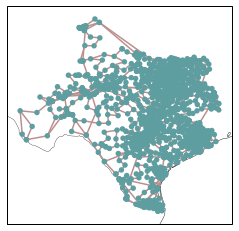

In [48]:
network.plot()
import matplotlib as plt
from matplotlib import cm

In [28]:
network.export_to_netcdf('texas_grid.netcdf')

INFO:pypsa.io:Exported network texas_grid.netcdf has lines, generators, buses


<xarray.Dataset>
Dimensions:                       (snapshots: 1, investment_periods: 0, lines_i: 3205, generators_i: 597, generators_t_q_i: 414, generators_t_status_i: 112, buses_i: 1999, buses_t_p_i: 1125, buses_t_q_i: 1125, buses_t_v_mag_pu_i: 1983, buses_t_v_ang_i: 1999)
Coordinates:
  * snapshots                     (snapshots) int64 0
  * investment_periods            (investment_periods) object 
  * lines_i                       (lines_i) object '100915' ... '104120'
  * generators_i                  (generators_i) object '12875' ... '14049'
  * generators_t_q_i              (generators_t_q_i) object '12875' ... '13416'
  * generators_t_status_i         (generators_t_status_i) object '12885' ... ...
  * buses_i                       (buses_i) object '3001001' ... '3008160'
  * buses_t_p_i                   (buses_t_p_i) object '3001001' ... '3008160'
  * buses_t_q_i                   (buses_t_q_i) object '3001001' ... '3008160'
  * buses_t_v_mag_pu_i            (buses_t_v_mag_pu_i) object '3001001' ... '...
  * buses_t_v_ang_i               (buses_t_v_ang_i) object '3001001' ... '300...
Data variables: (12/90)
    snapshots_snapshot            (snapshots) object 'now'
    snapshots_objective           (snapshots) int64 1
    snapshots_stores              (snapshots) int64 1
    snapshots_generators          (snapshots) int64 1
    investment_periods_objective  (investment_periods) object 
    investment_periods_years      (investment_periods) object 
    ...                            ...
    buses_v_mag_pu_max            (buses_i) float64 1.1 1.1 1.1 ... 1.1 1.1 1.1
    buses_v_mag_pu_min            (buses_i) float64 0.9 0.9 0.9 ... 0.9 0.9 0.9
    buses_t_p                     (snapshots, buses_t_p_i) float64 20.78 ... ...
    buses_t_q                     (snapshots, buses_t_q_i) float64 5.89 ... 2...
    buses_t_v_mag_pu              (snapshots, buses_t_v_mag_pu_i) float64 0.9...
    buses_t_v_ang                 (snapshots, buses_t_v_ang_i) float64 -0.39 ...
Attributes:
    network_name:           
    network_pypsa_version:  0.18.1
    network_srid:           4326

In [49]:
network.snapshots

Index(['now'], dtype='object', name='snapshot')

In [50]:
outputs.set_index

,UTC,375,376,390,391,403,404,405,440,441,...,14040,14041,14042,14043,14044,14045,14046,14047,14048,14049
0,2016-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,89.378163,17.500148,49.074791,85.394916,74.689301,73.460236,40.790739,41.609568,0.542111,40.035355
1,2016-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,79.083060,24.649092,43.910469,88.862461,88.071159,86.621887,70.110531,53.958899,1.290235,68.812188
2,2016-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,69.966352,31.313968,51.600229,81.840478,86.503277,85.079805,74.322424,66.825514,2.848022,72.946083
3,2016-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,56.599790,32.429953,77.638289,77.525417,77.675205,76.397006,76.963968,62.909490,7.295440,75.538709
4,2016-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,45.964904,20.054285,78.013996,84.401753,82.602793,81.243506,67.526658,55.168348,36.910110,66.276164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2016-12-31 19:00:00,1.821987,1.821987,1.239978,1.116151,1.029144,1.029144,1.029144,0.425163,0.447454,...,63.904573,77.867260,0.260791,33.390865,31.972322,31.446195,44.575749,15.737622,1.924633,43.750272
8780,2016-12-31 20:00:00,0.794466,0.794466,0.476492,0.428908,0.330221,0.330221,0.330221,0.111929,0.117797,...,57.506572,52.755050,4.407634,22.560801,27.027154,26.582403,39.584695,16.871325,1.000783,38.851645
8781,2016-12-31 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,38.826965,23.851248,4.450906,27.103367,38.351842,37.720736,26.128323,20.551174,0.631278,25.644465
8782,2016-12-31 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,33.980771,8.567781,11.015917,21.918688,42.123071,41.429907,16.935823,18.214693,0.292845,16.622197


In [54]:
network.branches().shape

(3205, 61)